# Comparing Block Error Rate (BLER) using different channel estimation method


In [1]:
import numpy as np
import time, os, torch
import matplotlib.pyplot as plt

from neoradium import Carrier, PDSCH, CdlChannel, AntennaPanel, Grid, random, LdpcEncoder, SnrScheduler

from ChEstNet import ChEstNet
from ChEstUtils import estimateChannelML, getPseudoPilotIndices


In [2]:
# Load the model:
modelPath = 'Models/BestModel.pth'
device = "cuda:0" if torch.cuda.is_available() else "mps" if torch.backends.mps.is_available() else "cpu"
model = ChEstNet(device)                                # Instantiate the model on the target device
model.loadParams(modelPath);                            # Load the trained model parameters

In [3]:
# Calculate block error rates
seed = 123

maxSlots = 1000                             # Number of Slots
snrScheduler = SnrScheduler(-13,0.2)        # Start at -13 dB, use increments of 0.2 dB

freqDomain = True                           # Apply channel in frequency domain
modulation = "16QAM"
codeRate = 490/1024
numLayers = 2

carrier = Carrier(numRbs=45, spacing=30)   # Create a carrier with 45 RBs and 30KHz subcarrier spacing
bwp = carrier.curBwp                       # The only bandwidth part in the carrier

# Create a 2-layer PDSCH object with type-2 DMRS on symbols 2 and 11
pdsch = PDSCH(bwp, numLayers=numLayers, nID=carrier.cellId, modulation=modulation)
pdsch.setDMRS(configType=2, additionalPos=1) # Specify the DMRS configuration

# Create the LDPC encoder and decoder:
ldpcEncoder = LdpcEncoder(baseGraphNo=1, modulation=pdsch.modems[0].modulation, 
                          txLayers=pdsch.numLayers, targetRate=codeRate)
ldpcDecoder = ldpcEncoder.getDecoder()

channel = CdlChannel(bwp, 'C', delaySpread=300, carrierFreq=4e9, dopplerShift=5,
                     txAntenna = AntennaPanel([2,4], polarization="x"),  # 16 TX antenna
                     rxAntenna = AntennaPanel([1,2], polarization="x"))  # 4 RX antenna

def equalizeAndDecode(rxGrid, chanEst):
    eqGrid, llrScales = rxGrid.equalize(chanEst)           # Equalization
    llrs = pdsch.getLLRsFromGrid(eqGrid, pdsch.dataIndices, llrScales)     
    rxCodedBlocks = ldpcDecoder.recoverRate(llrs[0], txBlockSize)
    decodedBlocks = ldpcDecoder.decode(rxCodedBlocks, numIter=20)
    decodedTxBlockWithCRC, crcMatch = ldpcDecoder.checkCrcAndMerge(decodedBlocks)

    cbErrors = len(crcMatch)-sum(crcMatch).item()
    return [cbErrors, len(crcMatch)], [decodedTxBlockWithCRC, crcMatch]

chEstMethods = ["LS (DMRS)", "ML (DMRS)", "Self-Refining", "Perfect"]
results = {}

for chEstMethod in chEstMethods:
    print(f'\nCalculating Block Error Rate for "{chEstMethod}" channel estimation')
    if chEstMethod=="Self-Refining":
        print("SNR(dB)  TX Blocks  Block Errors  BLER(%)  Ret. Saved  Rec. Code Blocks")
        print("-------  ---------  ------------  -------  ----------  ----------------")
    else:
        print("SNR(dB)  TX Blocks  Block Errors  BLER(%)")
        print("-------  ---------  ------------  -------")
        
    snrScheduler.reset()
    for snrDb in snrScheduler:
        random.setSeed(seed)
        channel.restart()                                           # Reset the channel and the bandwidth part associated with it
        
        totalRetransmissions = 0
        retransmissionsSaved = 0
        codeBlocksRecovered = 0
    
        t0 = time.time()                                            # Start the timer
        blockErrors = 0
        totalBlocks = 0
        for s in range(maxSlots):                                   # The inner loop doing 'numSlot' transmissions
            txGrid = bwp.createGrid(pdsch.numLayers)                # Create a resource grid with 2 layers
            pdsch.allocateResources(txGrid)                         # Allocat PDSCH resources including DMRS
            txBlockSize = pdsch.getTxBlockSize(codeRate)[0]         # Calculate the Transport Block Size (TBS)
            numBits = pdsch.getBitSizes(txGrid)[0]                  # Total number of PDSCH data bits available in grid
            txBlock = random.bits(txBlockSize)                      # Create random binary data
            txBits = ldpcEncoder.getRateMatchedCodeBlocks(txBlock, numBits)   # Segmentation, rate-matching, and encoding
            pdsch.populateGrid(txGrid, txBits)                      # Map/modulate the data to the resource grid

            channelMatrix = channel.getChannelMatrix()              # Get the channel matrix
            precoder = pdsch.getPrecodingMatrix(channelMatrix)      # Get the precoder matrix from PDSCH object
            precodedGrid = txGrid.precode(precoder)                 # Perform the precoding
            perfectChannel = channelMatrix @ precoder[None,...]     # Calculate the "precoded" ground-truth channel

            if freqDomain:
                rxGrid = precodedGrid.applyChannel(channelMatrix)   # Apply the channel in frequency domain
                noisyRxGrid = rxGrid.addNoise(snrDb=snrDb)          # Add noise in frequency domain
            else:
                txWaveform = precodedGrid.ofdmModulate()            # OFDM Modulation
                maxDelay = channel.getMaxDelay()                    # Get the max. channel delay
                txWaveform = txWaveform.pad(maxDelay)               # Pad with zeros
                rxWaveform = channel.applyToSignal(txWaveform)      # Apply channel in time domain
                noisyRxWaveform = rxWaveform.addNoise(snrDb=snrDb, nFFT=bwp.nFFT)  # Add noise in time domain
                offset = channel.getTimingOffset()                  # Get timing info for synchronization
                syncedWaveform = noisyRxWaveform.sync(offset)       # Synchronization
                noisyRxGrid = syncedWaveform.ofdmDemodulate(bwp)    # OFDM demodulation

            if chEstMethod=="LS (DMRS)":
                # LS Channel Estimation using DMRS
                lsChannelMatrix, noiseEst = noisyRxGrid.estimateChannelLS(pdsch.dmrs, polarInt=True, kernel='linear')
                blerInfo, _ = equalizeAndDecode(noisyRxGrid, lsChannelMatrix)

            elif chEstMethod=="ML (DMRS)":
                # ML using DMRS only
                pilotsGrid = pdsch.getGrid()
                dmrsIdx = pilotsGrid.getReIndexes("DMRS")
                mlChannelMatrix = estimateChannelML(model, dmrsIdx, pilotsGrid, noisyRxGrid)
                blerInfo, decodeInfo = equalizeAndDecode(noisyRxGrid, mlChannelMatrix)

            elif chEstMethod=="Self-Refining":
                pilotsGrid = pdsch.getGrid()
                dmrsIdx = pilotsGrid.getReIndexes("DMRS")
                mlChannelMatrix = estimateChannelML(model, dmrsIdx, pilotsGrid, noisyRxGrid)
                blerInfo, decodeInfo = equalizeAndDecode(noisyRxGrid, mlChannelMatrix)

                cbErrors, numCB = blerInfo
                decodedTxBlockWithCRC, crcMatch = decodeInfo
                # Now try using psuedo pilots
                # pseudo pilots are relevant only when: cbErrors ∈ {1,...,numCB-1}
                relevantCbErrors = np.arange(1,numCB)
                orgCbErrors = cbErrors
                while cbErrors in relevantCbErrors:
                    pseudoPilotIndices = getPseudoPilotIndices(pdsch, ldpcEncoder, pilotsGrid, decodedTxBlockWithCRC, crcMatch)
                    allPilotIndices = tuple(np.append(pseudoPilotIndices[i],dmrsIdx[i]) for i in [0,1,2])
                    mlChannelMatrix = estimateChannelML(model, allPilotIndices, pilotsGrid, noisyRxGrid)
                
                    blerInfo, decodeInfo = equalizeAndDecode(noisyRxGrid, mlChannelMatrix)
                    if blerInfo[0] == cbErrors: break
                    assert blerInfo[0]<cbErrors, f"Pseudo-Pilots made it worse!({blerInfo[0]}, {cbErrors})"
                    cbErrors = blerInfo[0]
                    decodedTxBlockWithCRC, crcMatch = decodeInfo
        
                totalRetransmissions += 1*(orgCbErrors in relevantCbErrors) # The retransmissions that could be saved
                codeBlocksRecovered  += orgCbErrors - cbErrors
                retransmissionsSaved += 1*(cbErrors==0 and orgCbErrors>0)

            elif chEstMethod=="Perfect":
                blerInfo, _ = equalizeAndDecode(noisyRxGrid, perfectChannel)
            
            channel.goNext()                        # Prepare the channel model for the next slot
            blockErrors += blerInfo[0]
            totalBlocks += blerInfo[1]
            bler = blockErrors*100/totalBlocks
            print(f"\r{snrDb:7.1f}  {totalBlocks:9,d}  {blockErrors:12,d}  {bler:7.2f}  " +
                  (f"{retransmissionsSaved:10,d} {codeBlocksRecovered:17,d}" if chEstMethod=="Self-Refining" else ""), end='')

        snrScheduler.setData(bler)
        print("")

    results[chEstMethod] = snrScheduler.getSnrsAndData()



Calculating Block Error Rate for "LS (DMRS)" channel estimation
SNR(dB)  TX Blocks  Block Errors  BLER(%)
-------  ---------  ------------  -------
  -13.0      4,000         2,798    69.95  
  -13.2      4,000         2,915    72.88  
  -13.4      4,000         3,118    77.95  
  -13.6      4,000         3,509    87.72  
  -13.8      4,000         3,915    97.88  
  -14.0      4,000         3,997    99.92  
  -14.2      4,000         4,000   100.00  
  -14.4      4,000         4,000   100.00  
  -12.8      4,000         2,661    66.53  
  -12.6      4,000         2,356    58.90  
  -12.4      4,000         1,826    45.65  
  -12.2      4,000         1,388    34.70  
  -12.0      4,000         1,078    26.95  
  -11.8      4,000           818    20.45  
  -11.6      4,000           684    17.10  
  -11.4      4,000           578    14.45  
  -11.2      4,000           464    11.60  
  -11.0      4,000           337     8.43  
  -10.8      4,000           150     3.75  
  -10.6      4,

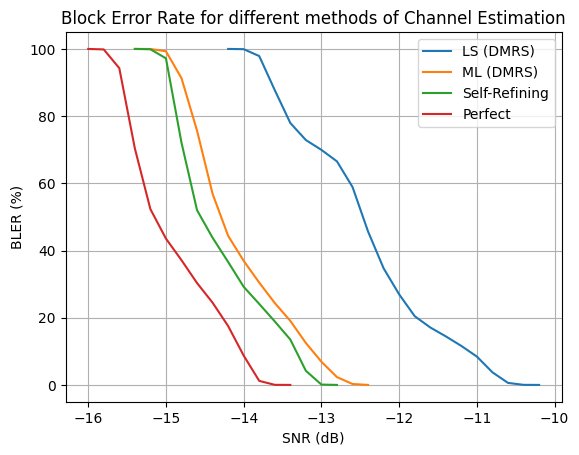

In [4]:
for i,chEstMethod in enumerate(chEstMethods):
    snrDbs, blers = results[chEstMethod]
    plt.plot(snrDbs, blers, label=chEstMethod)
plt.legend()
plt.title("Block Error Rate for different methods of Channel Estimation");
plt.grid()
plt.xlabel("SNR (dB)")
plt.ylabel("BLER (%)")
plt.show()